# Dogs vs Cats (TF 2.1.5 -Softmax)
**End to End Image Classification project using TensorFlow**

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cat_dog.gif" width="750" align="center">

In [1]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [2]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Flatten,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

## Organize data OLD SCHOOL!

In [3]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip --qq cats_and_dogs_filtered.zip

--2024-12-08 09:51:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  73.4MB/s    in 0.9s    

2024-12-08 09:51:52 (73.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
!pip install split_folders -q

## Splitting folders
We will split the input in 3 different dataset: train, val, test

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/splitting_folder.png" width="450" align="center">

In [5]:
import splitfolders
input_folder = 'cats_and_dogs_filtered/train/'
output_folder = 'data/'

In [6]:
splitfolders.ratio(input_folder,output_folder,seed=667,ratio=(.6,.2,.2))

Copying files: 2000 files [00:00, 2699.20 files/s]


In [7]:
img_height, img_width = (150,150)
batch_size = 10

train_data_dir = 'data/train'
validation_data_dir = 'data/val'
test_data_dir = 'data/test'

## NEW WAY after TF2.1.5 (all classes divided inside subfolders)

In [8]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
!unzip --qq dogs_cats_all.zip

--2024-12-08 09:52:05--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.150.130, 52.95.150.90, 52.95.149.30, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.150.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68391667 (65M) [application/octet-stream]
Saving to: ‘dogs_cats_all.zip’

dogs_cats_all.zip   100%[===================>]  65.22M  16.7MB/s    in 3.9s    

2024-12-08 09:52:09 (16.7 MB/s) - ‘dogs_cats_all.zip’ saved [68391667/68391667]




<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/augmentation.png" width="800" align="center">

In [9]:
dataset = 'dogs_cats_all'

image_size = (150, 150)
batch_size = 32
ch=3

In [10]:
## NO AUGMENTATION
# train_generator = image_dataset_from_directory(dataset,
#                                                 validation_split=0.2,
#                                                 subset="training",
#                                                 seed=667,
#                                                 image_size=image_size,
#                                                 batch_size=batch_size,
#                                                 label_mode = 'categorical'
#                                                 )

# validation_generator = image_dataset_from_directory(dataset,
#                                                 validation_split=0.2,
#                                                 subset="validation",
#                                                 seed=667,
#                                                 image_size=image_size,
#                                                 batch_size=batch_size,
#                                                 label_mode = 'categorical'
#                                                 )

In [11]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    zoom_range=0.2,
                                    shear_range=0.2,
                                    brightness_range=[0.8, 1.2],
                                    fill_mode='nearest',
                                    validation_split=0.2
                                    )
# Create the generators
train_generator = train_datagen.flow_from_directory(
                                                    dataset,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=667
                                                    )

# Create validation ImageDataGenerator (only rescaling)
validation_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        validation_split=0.2 #20% of dataset folder
                                        )

validation_generator = validation_datagen.flow_from_directory(
                                                            dataset,
                                                            target_size=image_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            subset='validation',
                                                            seed=667
                                                            )

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [12]:
#class names
class_names = list(train_generator.class_indices.keys())

In [13]:
#class_names = ['cats','dogs']

In [14]:
num_classes = len(class_names)
num_classes

2

In [ ]:
model = Sequential()

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Convolution Layer 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Convolution Layer 3
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      10,617,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,712,770 (40.87 MB)

 Trainable params: 10,711,810 (40.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
file_path = "weights_best.keras"  # for TF2.17
checkpoint = ModelCheckpoint(
                            file_path,
                            monitor='val_accuracy',
                            mode='max',
                            verbose=0,
                            save_best_only=True,
                            )
early = EarlyStopping(
                    monitor="val_accuracy",
                    mode="max",
                    patience=5,
                    restore_best_weights=True
                    )
callbacks_list = [checkpoint, early]

EPOCHS = 20
history = model.fit(
                    train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=2,
                    )

Epoch 1/20
75/75 - 21s - 278ms/step - accuracy: 0.7287 - loss: 0.5488 - val_accuracy: 0.7583 - val_loss: 0.7149
Epoch 2/20
75/75 - 21s - 277ms/step - accuracy: 0.7325 - loss: 0.5399 - val_accuracy: 0.7117 - val_loss: 0.8437
Epoch 3/20
75/75 - 20s - 264ms/step - accuracy: 0.7333 - loss: 0.5488 - val_accuracy: 0.7350 - val_loss: 0.8231
Epoch 4/20
75/75 - 19s - 257ms/step - accuracy: 0.7471 - loss: 0.5236 - val_accuracy: 0.7533 - val_loss: 0.7922
Epoch 5/20
75/75 - 20s - 270ms/step - accuracy: 0.7392 - loss: 0.5354 - val_accuracy: 0.7517 - val_loss: 0.8422
Epoch 6/20
75/75 - 22s - 288ms/step - accuracy: 0.7404 - loss: 0.5234 - val_accuracy: 0.7600 - val_loss: 0.8633


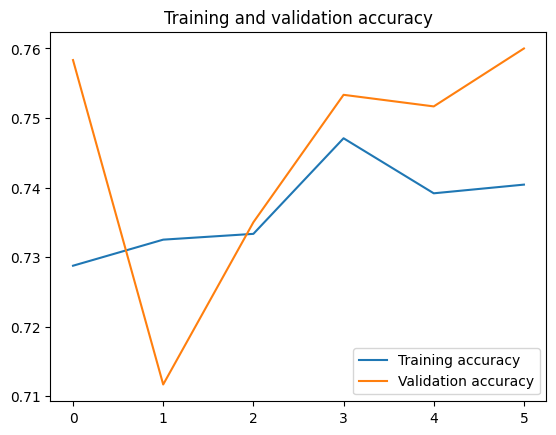

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

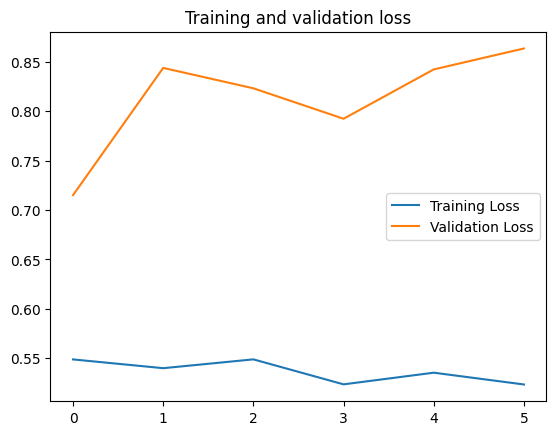

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [15]:
# Struttura della nostra Neural Network
model =Sequential()

model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3),activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

# Output layer - Number neuron == number classes
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,634 (13.17 MB)

 Trainable params: 3,453,634 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
file_path="weights_best.keras"
checkpoint = ModelCheckpoint(
                            file_path,
                            monitor='val_accuracy',
                            mode='max',
                            verbose=0,
                            save_best_only=True,
                            )

early = EarlyStopping(
                    monitor="val_accuracy",
                    mode="max",
                    patience=5,
                    restore_best_weights=True
                    )
callbacks_list = [checkpoint, early]

EPOCHS = 20
history = model.fit(
                    train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=2,
                    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 - 31s - 413ms/step - accuracy: 0.4992 - loss: 0.6957 - val_accuracy: 0.5433 - val_loss: 0.6872
Epoch 2/20
75/75 - 20s - 265ms/step - accuracy: 0.5671 - loss: 0.6821 - val_accuracy: 0.5750 - val_loss: 0.6767
Epoch 3/20
75/75 - 23s - 301ms/step - accuracy: 0.5850 - loss: 0.6678 - val_accuracy: 0.5767 - val_loss: 0.6850
Epoch 4/20
75/75 - 47s - 627ms/step - accuracy: 0.6142 - loss: 0.6512 - val_accuracy: 0.6567 - val_loss: 0.6219
Epoch 5/20
75/75 - 27s - 361ms/step - accuracy: 0.6225 - loss: 0.6467 - val_accuracy: 0.6650 - val_loss: 0.6081
Epoch 6/20
75/75 - 20s - 266ms/step - accuracy: 0.6600 - loss: 0.6241 - val_accuracy: 0.6583 - val_loss: 0.6053
Epoch 7/20
75/75 - 23s - 306ms/step - accuracy: 0.6671 - loss: 0.6138 - val_accuracy: 0.6817 - val_loss: 0.5707
Epoch 8/20
75/75 - 23s - 307ms/step - accuracy: 0.6604 - loss: 0.6120 - val_accuracy: 0.6783 - val_loss: 0.5825
Epoch 9/20
75/75 - 37s - 488ms/step - accuracy: 0.6762 - loss: 0.5985 - val_accuracy: 0.7000 - val_loss: 0.5563
Epo

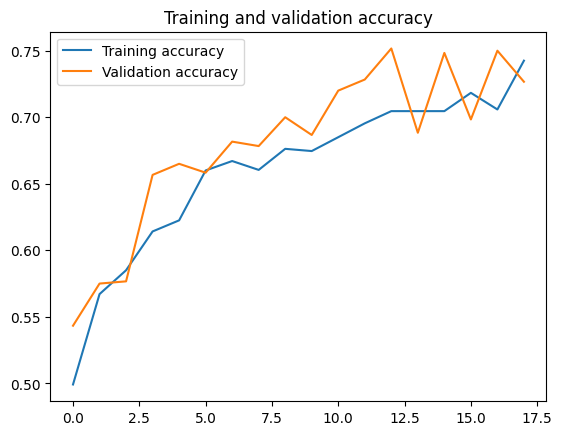

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

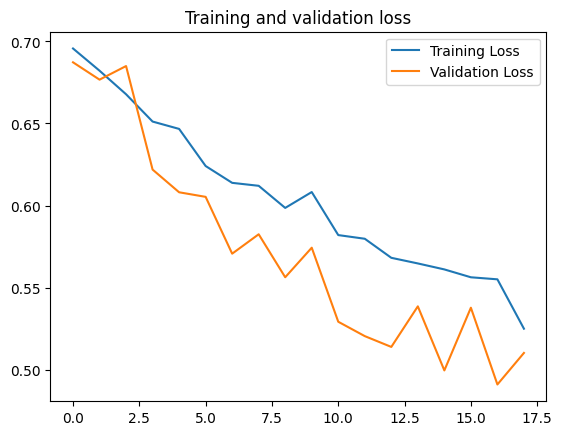

In [19]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [20]:
model.save('dog_cat_final.keras')

In [21]:
model = load_model('dog_cat_final.keras')

In [ ]:
# from sklearn.metrics import classification_report
# import pandas as pd
# import seaborn as sns

# prediction_classes = np.array([])
# true_classes =  np.array([])

# for x, y in validation_generator:
#     prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x), axis = -1)])
#     true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])

In [23]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import numpy as np

def get_predictions(model, data_generator):
    data_generator.reset()
    num_samples = data_generator.n
    prediction_classes = np.zeros(num_samples, dtype=np.int32)
    true_classes = np.zeros(num_samples, dtype=np.int32)

    idx = 0
    for i in range(len(data_generator)):
        x, y = data_generator[i]
        batch_size = x.shape[0]
        pred = model.predict(x, batch_size=batch_size, verbose=0)
        end_idx = min(idx + batch_size, num_samples)
        prediction_classes[idx:end_idx] = np.argmax(pred, axis=-1)
        true_classes[idx:end_idx] = np.argmax(y, axis=-1)
        idx += batch_size
    return prediction_classes, true_classes

prediction_classes, true_classes = get_predictions(model, validation_generator)

## Print first 50 observation

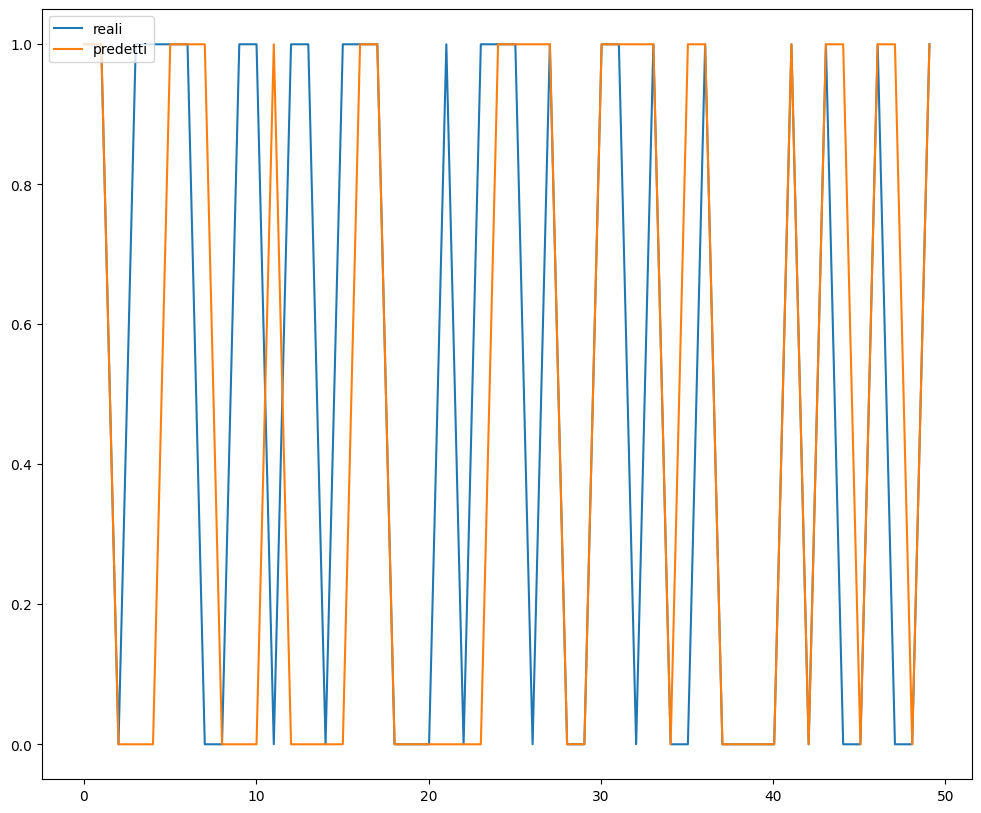

In [24]:
length = prediction_classes.shape[0] # 30
x = np.linspace(0,length,length)

plt.figure(figsize=(12,10))
plt.plot(x[:50], true_classes[:50], label='reali')
plt.plot(x[:50], prediction_classes[:50], label='predetti')
plt.legend(loc=2);

In [25]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       300
           1       0.76      0.73      0.75       300

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600



# Confusion Matrix

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cf_dog.jpg" width="800" align="center">

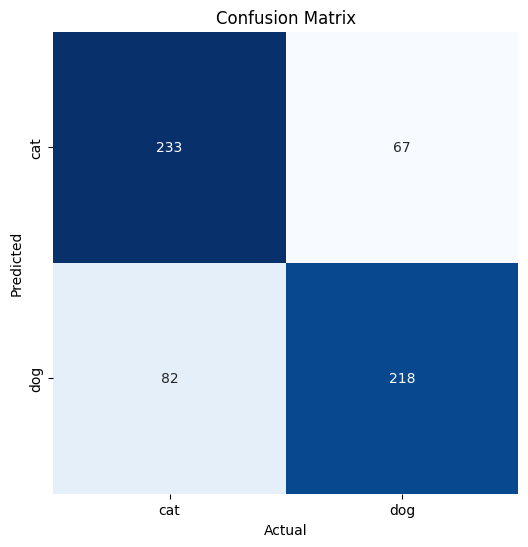

In [26]:
cm = pd.crosstab(true_classes,prediction_classes,
                 rownames = ['Predicted'],
                 colnames = ['Actual'])

plt.figure(figsize=(6,6))
plt.title('Confusion Matrix')
labels = ['cat','dog']
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,cmap='Blues',annot=True,fmt='g',cbar=False);

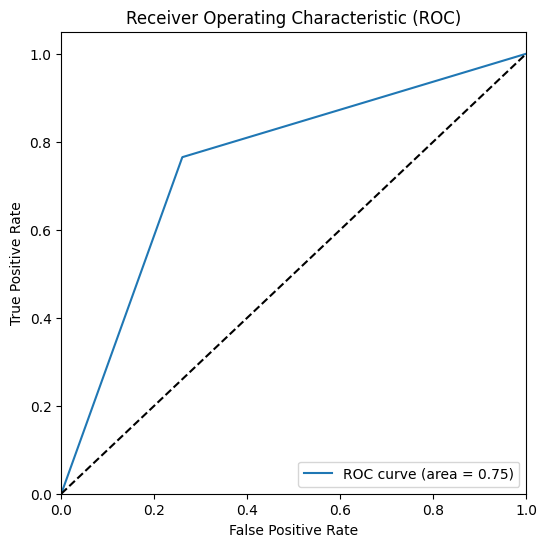

In [27]:
from sklearn.metrics import roc_curve, auc
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(true_classes,prediction_classes)

## Testing with New Data

In [ ]:
#{'cats': 0, 'dogs': 1}

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yolo.jpg to yolo.jpg


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

classes = {0:"cat",
           1:"dog",}

# predicting images
path = 'dog.jpg'
#resize to the right input format
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
pred = model.predict(images)
print(pred)
pred = np.argmax(pred, axis=-1)[0]  ## Finalmente con la softmax!
res = classes[pred]
print("class= "+str(pred),", it's a:",res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
[[7.5791928e-04 9.9924207e-01]]
class= 1 , it's a: dog


## Convert tflite

In [ ]:
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open('my_model.tflite', "wb").write(tfmodel)

Saved artifact at '/tmp/tmpgam_z3zd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140191477279104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477282800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477326144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477330016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477450704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477452992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477457216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477459504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477665632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477668448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401914776654

13819156